In [ ]:
# =============================================================================
# SETUP AMBIENTE E CARICAMENTO DATI (APPROCCIO 2)
# 1. Installazione librerie per calcolo DTW.
# 2. Definizione funzioni di caricamento dati (Primi 100ms).
# =============================================================================

try:
    import dtaidistance
except ImportError:
    !pip install dtaidistance

from google.colab import drive
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from dtaidistance import dtw
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

# Montaggio Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# --- FUNZIONI DI CARICAMENTO ---
def load_transient_data_lb(excel_path, data_folder, is_train=True, window_size=100):
    print(f"Caricamento dati da: {data_folder}...")
    try:
        df_labels = pd.read_excel(excel_path, header=1)
    except:
        df_labels = pd.read_excel(excel_path, header=0)

    cols = list(df_labels.columns)
    mapping = {}
    if len(cols) >= 1: mapping[cols[0]] = 'Case#'
    if len(cols) >= 2: mapping[cols[1]] = 'Spacecraft#'
    if len(cols) >= 3 and is_train: mapping[cols[2]] = 'Condition'
    df_labels = df_labels.rename(columns=mapping)
    df_labels = df_labels.dropna(subset=['Case#'])

    all_data = []
    for index, row in df_labels.iterrows():
        try:
            case_id = int(row['Case#'])
            filename_pad = f"Case{case_id:03d}.csv"
            filename_nopad = f"Case{case_id}.csv"

            file_path = os.path.join(data_folder, filename_pad)
            if not os.path.exists(file_path):
                file_path = os.path.join(data_folder, filename_nopad)

            if os.path.exists(file_path):
                df_signals = pd.read_csv(file_path, nrows=window_size)
                new_row = row.to_dict()

                for s in ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']:
                    vals = df_signals[s].values if s in df_signals.columns else np.zeros(window_size)
                    if len(vals) < window_size:
                        vals = np.pad(vals, (0, window_size - len(vals)), 'edge')
                    new_row[f"{s}_vec"] = vals

                # --- GESTIONE TARGET (CORRETTA) ---
                if is_train:
                    cond = str(row['Condition']).lower()
                    new_row['Target_Task1'] = 0 if 'normal' in cond else 1
                    new_row['Target_Task2'] = 0
                    new_row['Target_Task3'] = 0
                    new_row['Target_Task4'] = 0
                    new_row['Target_Task5'] = 100.0 # <--- DEFAULT: Apertura 100%

                    if 'anomaly' in cond:
                        new_row['Target_Task2'] = 2
                        for i, bp in enumerate(['BP1','BP2','BP3','BP4','BP5','BP6','BP7','BV1']):
                            if bp in df_labels.columns and str(row[bp]).lower() in ['yes', 'x', '1']:
                                new_row['Target_Task3'] = i + 1

                    elif 'fault' in cond:
                        new_row['Target_Task2'] = 3
                        for i, sv in enumerate(['SV1','SV2','SV3','SV4']):
                            # Cerchiamo la colonna della valvola che ha un valore numerico < 100
                            if sv in df_labels.columns:
                                val = row[sv]
                                if pd.notnull(val) and isinstance(val, (int, float)) and val < 100:
                                    new_row['Target_Task4'] = i + 1
                                    new_row['Target_Task5'] = float(val) # <--- SALVIAMO L'APERTURA REALE
                                    break

                all_data.append(new_row)
        except Exception as e:
            continue

    return pd.DataFrame(all_data)

# --- PERCORSI E CARICAMENTO ---
PATH_TRAIN_XL = "/content/drive/MyDrive/train/labels.xlsx"
PATH_TRAIN_DATA = "/content/drive/MyDrive/train/data/"
PATH_TEST_XL = "/content/drive/MyDrive/test/labels_spacecraft.xlsx"
PATH_TEST_DATA = "/content/drive/MyDrive/test/data/"

df_train_lb = load_transient_data_lb(PATH_TRAIN_XL, PATH_TRAIN_DATA, is_train=True)
df_test_lb = load_transient_data_lb(PATH_TEST_XL, PATH_TEST_DATA, is_train=False)

print(f"\n✅ Dataset caricati in memoria.")
print(f"Train size: {len(df_train_lb)} | Test size: {len(df_test_lb)}")
# Verifica veloce
if 'Target_Task5' in df_train_lb.columns:
    print(f"Verifica Target 5: {df_train_lb['Target_Task5'].unique()}")
else:
    print("❌ ERRORE: Target_Task5 ancora mancante!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 39.8 MB/s eta 0:00:00
Mounted at /content/drive
Caricamento dati da: /content/drive/MyDrive/Manutenzione/train/data/...
Caricamento dati da: /content/drive/MyDrive/Manutenzione/test/data/...

✅ Dataset caricati in memoria.
Train size: 177 | Test size: 46
Verifica Target 5: [100.   0.  25.  50.  75.]


--- RISULTATI ANALITICI CROSS-VALIDATION: TASK 1 ---
🔹 Dati analizzati: 177 casi totali (Normali vs Anomali)
🔹 Metodo: Distanza DTW su sensore P1
🔹 Accuratezza Globale CV: 100.00%
🔹 Soglia di Anomalia media stimata: 0.0000


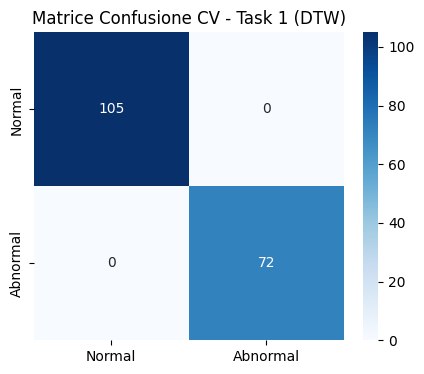

In [ ]:
# =============================================================================
# TASK 1: CROSS-VALIDATION (DTW ANOMALY DETECTION)
# =============================================================================
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = df_train_lb.index.values
y = df_train_lb['Target_Task1'].values

y_true_all, y_pred_all = [], []
thresholds = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    train_set = df_train_lb.iloc[train_idx]
    val_set = df_train_lb.iloc[val_idx]

    # Template Normale e Soglia
    normals_train = train_set[train_set['Target_Task1'] == 0]
    template_P1 = np.mean(np.stack(normals_train['P1_vec'].values), axis=0)

    dists_normal = [dtw.distance(row['P1_vec'], template_P1) for _, row in normals_train.iterrows()]
    thresh = np.mean(dists_normal) + 3 * np.std(dists_normal)
    thresholds.append(thresh)

    # Test sul fold
    for _, row in val_set.iterrows():
        d = dtw.distance(row['P1_vec'], template_P1)
        y_pred_all.append(1 if d > thresh else 0)
        y_true_all.append(row['Target_Task1'])

# --- OUTPUT ANALITICO STANDARDIZZATO ---
acc = accuracy_score(y_true_all, y_pred_all)
print(f"--- RISULTATI ANALITICI CROSS-VALIDATION: TASK 1 ---")
print(f"🔹 Dati analizzati: {len(y)} casi totali (Normali vs Anomali)")
print(f"🔹 Metodo: Distanza DTW su sensore P1")
print(f"🔹 Accuratezza Globale CV: {acc*100:.2f}%")
print(f"🔹 Soglia di Anomalia media stimata: {np.mean(thresholds):.4f}")

cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Matrice Confusione CV - Task 1 (DTW)')
plt.show()

In [ ]:
# =============================================================================
# TASK 1: PREDIZIONE TEST SET (DTW)
# 1. Calcolo Template e Soglia su TUTTO il training set.
# 2. Applicazione al Test Set.
# =============================================================================

# 1. Training su tutto il dataset
normals_full = df_train_lb[df_train_lb['Target_Task1'] == 0]
FULL_TEMPLATE_P1 = np.mean(np.stack(normals_full['P1_vec'].values), axis=0)

dists_full = [dtw.distance(row['P1_vec'], FULL_TEMPLATE_P1) for _, row in normals_full.iterrows()]
FINAL_THRESHOLD_T1 = np.mean(dists_full) + 3 * np.std(dists_full)

print(f"Soglia Finale Task 1: {FINAL_THRESHOLD_T1:.4f}")

# 2. Predizione
test_preds_t1 = []
test_dists_t1 = []

for _, row in df_test_lb.iterrows():
    d = dtw.distance(row['P1_vec'], FULL_TEMPLATE_P1)
    test_dists_t1.append(d)
    test_preds_t1.append(1 if d > FINAL_THRESHOLD_T1 else 0)

df_test_lb['Task1_Pred'] = test_preds_t1
df_test_lb['DTW_Dist_Normal'] = test_dists_t1

# Analisi
print("\nDistribuzione Predizioni Task 1 (Test Set):")
print(df_test_lb['Task1_Pred'].value_counts().rename({0: 'Normal', 1: 'Abnormal'}))

print("\nSuddivisione per Spacecraft:")
print(pd.crosstab(df_test_lb['Spacecraft#'], df_test_lb['Task1_Pred']).rename(columns={0: 'Normal', 1: 'Abnormal'}))

Soglia Finale Task 1: 0.0000

Distribuzione Predizioni Task 1 (Test Set):
Task1_Pred
Abnormal    26
Normal      20
Name: count, dtype: int64

Suddivisione per Spacecraft:
Task1_Pred   Normal  Abnormal
Spacecraft#                  
1                10        13
4                10        13


--- RISULTATI ANALITICI CROSS-VALIDATION: TASK 2 ---
🔹 Dati analizzati: 72 casi anomali (Bolle vs Valvole)
🔹 Metodo: 1-Nearest Neighbor DTW su sensori P1 + P6
🔹 Accuratezza Globale CV: 100.00%
🔹 Soglia per identificare guasti 'Unknown': 0.8505


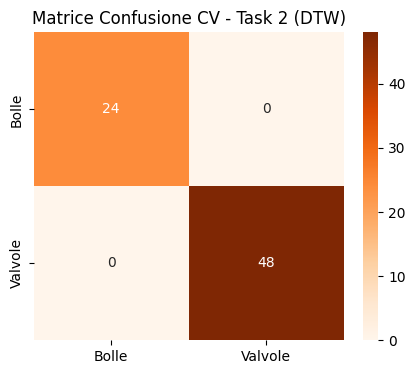

In [ ]:
# =============================================================================
# TASK 2: CROSS-VALIDATION (DTW 1-NN CLASSIFICATION)
# =============================================================================
df_anom = df_train_lb[df_train_lb['Target_Task1'] == 1].copy()
X = df_anom.index.values
y = df_anom['Target_Task2'].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_true_all, y_pred_all = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    train_set = df_anom.iloc[train_idx]
    val_set = df_anom.iloc[val_idx]

    for _, val_row in val_set.iterrows():
        best_dist = float('inf')
        best_label = -1
        for _, train_row in train_set.iterrows():
            d = dtw.distance(val_row['P1_vec'], train_row['P1_vec']) + dtw.distance(val_row['P6_vec'], train_row['P6_vec'])
            if d < best_dist:
                best_dist, best_label = d, train_row['Target_Task2']

        y_pred_all.append(best_label)
        y_true_all.append(val_row['Target_Task2'])

# Calcolo Soglia Unknown (su tutto il set anomalo)
distances =[dtw.distance(df_anom.iloc[i]['P1_vec'], df_anom.iloc[j]['P1_vec']) for i in range(len(df_anom)) for j in range(i+1, len(df_anom))]
THRESHOLD_UNKNOWN = np.mean(distances) + 2*np.std(distances)

# --- OUTPUT ANALITICO STANDARDIZZATO ---
acc = accuracy_score(y_true_all, y_pred_all)
print(f"--- RISULTATI ANALITICI CROSS-VALIDATION: TASK 2 ---")
print(f"🔹 Dati analizzati: {len(y)} casi anomali (Bolle vs Valvole)")
print(f"🔹 Metodo: 1-Nearest Neighbor DTW su sensori P1 + P6")
print(f"🔹 Accuratezza Globale CV: {acc*100:.2f}%")
print(f"🔹 Soglia per identificare guasti 'Unknown': {THRESHOLD_UNKNOWN:.4f}")

cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Bolle', 'Valvole'], yticklabels=['Bolle', 'Valvole'])
plt.title('Matrice Confusione CV - Task 2 (DTW)')
plt.show()

In [ ]:
# =============================================================================
# TASK 2: PREDIZIONE TEST SET (DTW 1-NN)
# 1. Confronto ogni anomalia test con TUTTE le anomalie training.
# 2. Assegnazione classe del vicino più prossimo.
# 3. Gestione Unknown se la distanza minima > Soglia.
# =============================================================================

# Prendiamo solo quelli predetti anomali dal Task 1
mask_anom = df_test_lb['Task1_Pred'] == 1
test_anomalies = df_test_lb[mask_anom]

# Dataset di riferimento (Tutte le anomalie note)
train_anomalies_full = df_train_lb[df_train_lb['Target_Task1'] == 1]

preds_t2 = []

print(f"Classificazione di {len(test_anomalies)} anomalie nel test set...")

for idx, row in test_anomalies.iterrows():
    best_dist = float('inf')
    best_match_idx = -1

    # 1-NN Search
    for train_idx, train_row in train_anomalies_full.iterrows():
        d = dtw.distance(row['P1_vec'], train_row['P1_vec']) + \
            dtw.distance(row['P6_vec'], train_row['P6_vec'])

        if d < best_dist:
            best_dist = d
            best_match_idx = train_idx

    # Logica Unknown
    # Usiamo la distanza su P1 normalizzata rispetto al template normale per coerenza
    dist_from_normal = row['DTW_Dist_Normal']

    # Prendiamo la classe del vicino
    nearest_label = train_anomalies_full.loc[best_match_idx, 'Target_Task2']

    # Check euristico per Unknown (se distanza > soglia calcolata prima)
    # La soglia qui usata è su P1
    dist_p1_nearest = dtw.distance(row['P1_vec'], train_anomalies_full.loc[best_match_idx, 'P1_vec'])

    if dist_p1_nearest > THRESHOLD_UNKNOWN:
        preds_t2.append(1) # Unknown
    else:
        preds_t2.append(nearest_label)

# Salvataggio
df_test_lb.loc[mask_anom, 'Task2_Pred'] = preds_t2
df_test_lb.loc[~mask_anom, 'Task2_Pred'] = 0

print("\nRisultati Task 2 (Test Set):")
print(df_test_lb['Task2_Pred'].value_counts().rename({0: 'Normal', 1: 'Unknown', 2: 'Bolle', 3: 'Valvole'}))

Classificazione di 26 anomalie nel test set...

Risultati Task 2 (Test Set):
Task2_Pred
Normal     20
Bolle      10
Valvole    10
Unknown     6
Name: count, dtype: int64


--- RISULTATI ANALITICI CROSS-VALIDATION: TASK 3 ---
🔹 Dati analizzati: 24 casi di 'Bubble Anomaly' (8 posizioni)
🔹 Metodo: 1-Nearest Neighbor DTW su sensore P1
🔹 Accuratezza Globale CV: 100.00%


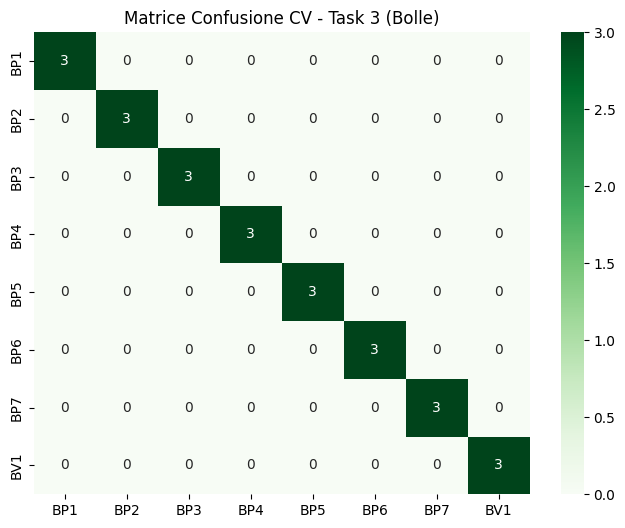

In [ ]:
# =============================================================================
# TASK 3: CROSS-VALIDATION (LOCALIZZAZIONE BOLLE - DTW)
# =============================================================================
df_bubbles = df_train_lb[df_train_lb['Target_Task2'] == 2].copy()
X = df_bubbles.index.values
y = df_bubbles['Target_Task3'].values

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3-Fold per pochi dati
y_true_all, y_pred_all = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    train_set = df_bubbles.iloc[train_idx]
    val_set = df_bubbles.iloc[val_idx]

    for _, val_row in val_set.iterrows():
        best_dist = float('inf')
        best_loc = -1
        for _, train_row in train_set.iterrows():
            d = dtw.distance(val_row['P1_vec'], train_row['P1_vec'])
            if d < best_dist:
                best_dist, best_loc = d, train_row['Target_Task3']

        y_pred_all.append(best_loc)
        y_true_all.append(val_row['Target_Task3'])

# --- OUTPUT ANALITICO STANDARDIZZATO ---
acc = accuracy_score(y_true_all, y_pred_all)
print(f"--- RISULTATI ANALITICI CROSS-VALIDATION: TASK 3 ---")
print(f"🔹 Dati analizzati: {len(y)} casi di 'Bubble Anomaly' (8 posizioni)")
print(f"🔹 Metodo: 1-Nearest Neighbor DTW su sensore P1")
print(f"🔹 Accuratezza Globale CV: {acc*100:.2f}%")

labels_map = [f'BP{i}' for i in range(1, 8)] + ['BV1']
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels_map, yticklabels=labels_map)
plt.title('Matrice Confusione CV - Task 3 (Bolle)')
plt.show()

In [ ]:
# =============================================================================
# TASK 3: PREDIZIONE TEST SET (DTW)
# =============================================================================

mask_bubbles = df_test_lb['Task2_Pred'] == 2
test_bubbles = df_test_lb[mask_bubbles]
train_bubbles_full = df_train_lb[df_train_lb['Target_Task2'] == 2]

preds_t3 = []

if len(test_bubbles) > 0:
    print(f"Localizzazione di {len(test_bubbles)} bolle nel test set...")
    for _, row in test_bubbles.iterrows():
        best_dist = float('inf')
        best_loc = -1

        for _, train_row in train_bubbles_full.iterrows():
            d = dtw.distance(row['P1_vec'], train_row['P1_vec'])
            if d < best_dist:
                best_dist = d
                best_loc = train_row['Target_Task3']
        preds_t3.append(best_loc)

    df_test_lb.loc[mask_bubbles, 'Task3_Pred'] = preds_t3

    # Report Analitico
    print("\nLocalizzazioni Trovate:")
    labels_map = ['N/A'] + [f'BP{i}' for i in range(1, 8)] + ['BV1']
    mapped_preds = [labels_map[int(p)] for p in preds_t3]
    print(pd.Series(mapped_preds).value_counts())
else:
    print("Nessuna bolla da localizzare.")

Localizzazione di 10 bolle nel test set...

Localizzazioni Trovate:
BP2    2
BP1    2
BP7    2
BP6    1
BP4    1
BP3    1
BP5    1
Name: count, dtype: int64


--- RISULTATI ANALITICI CROSS-VALIDATION: TASK 4 ---
🔹 Dati analizzati: 48 casi di 'Valve Fault' (SV1-SV4)
🔹 Metodo: 1-Nearest Neighbor DTW su sensori P1 + P6
🔹 Accuratezza Globale CV: 100.00%


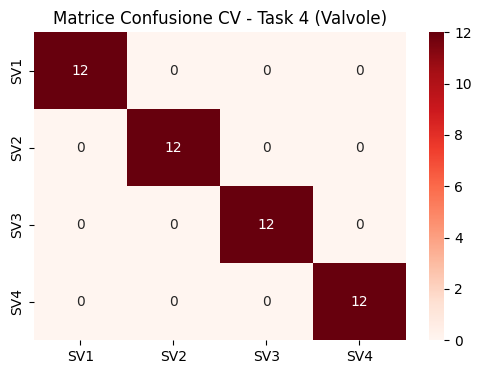

In [ ]:
# =============================================================================
# TASK 4: CROSS-VALIDATION (LOCALIZZAZIONE VALVOLE - DTW)
# =============================================================================
df_valves = df_train_lb[df_train_lb['Target_Task2'] == 3].copy()
X = df_valves.index.values
y = df_valves['Target_Task4'].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_true_all, y_pred_all = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    train_set = df_valves.iloc[train_idx]
    val_set = df_valves.iloc[val_idx]

    for _, val_row in val_set.iterrows():
        best_dist = float('inf')
        best_loc = -1
        for _, train_row in train_set.iterrows():
            # P1 e P6 combinati per localizzare
            d = dtw.distance(val_row['P1_vec'], train_row['P1_vec']) + dtw.distance(val_row['P6_vec'], train_row['P6_vec'])
            # Somma delle distanze DTW per i sensori P3, P4, P6, P7
            #d = dtw.distance(val_row['P3_vec'], train_row['P3_vec']) + \
            #dtw.distance(val_row['P4_vec'], train_row['P4_vec']) + \
            #dtw.distance(val_row['P6_vec'], train_row['P6_vec']) + \
            #dtw.distance(val_row['P7_vec'], train_row['P7_vec'])

            if d < best_dist:
                best_dist, best_loc = d, train_row['Target_Task4']

        y_pred_all.append(best_loc)
        y_true_all.append(val_row['Target_Task4'])

# --- OUTPUT ANALITICO STANDARDIZZATO ---
acc = accuracy_score(y_true_all, y_pred_all)
print(f"--- RISULTATI ANALITICI CROSS-VALIDATION: TASK 4 ---")
print(f"🔹 Dati analizzati: {len(y)} casi di 'Valve Fault' (SV1-SV4)")
print(f"🔹 Metodo: 1-Nearest Neighbor DTW su sensori P1 + P6")
#print(f"🔹 Metodo: 1-Nearest Neighbor DTW su sensori P3 + P4 + P6 + P7")
print(f"🔹 Accuratezza Globale CV: {acc*100:.2f}%")

labels_map = [f'SV{i}' for i in range(1, 5)]
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels_map, yticklabels=labels_map)
plt.title('Matrice Confusione CV - Task 4 (Valvole)')
plt.show()

In [ ]:
# =============================================================================
# TASK 4: PREDIZIONE TEST SET (DTW)
# =============================================================================

mask_valves = df_test_lb['Task2_Pred'] == 3
test_valves = df_test_lb[mask_valves]
train_valves_full = df_train_lb[df_train_lb['Target_Task2'] == 3]

preds_t4 = []

if len(test_valves) > 0:
    print(f"Localizzazione di {len(test_valves)} valvole nel test set...")
    for _, row in test_valves.iterrows():
        best_dist = float('inf')
        best_loc = -1

        for _, train_row in train_valves_full.iterrows():
            d = dtw.distance(row['P1_vec'], train_row['P1_vec']) + dtw.distance(row['P6_vec'], train_row['P6_vec'])
             # Somma delle distanze DTW per i sensori P3, P4, P6, P7
            # d = dtw.distance(val_row['P3_vec'], train_row['P3_vec']) + dtw.distance(val_row['P4_vec'], train_row['P4_vec']) + dtw.distance(val_row['P6_vec'], train_row['P6_vec']) + dtw.distance(val_row['P7_vec'], train_row['P7_vec'])

            if d < best_dist:
                best_dist = d
                best_loc = train_row['Target_Task4']
        preds_t4.append(best_loc)

    df_test_lb.loc[mask_valves, 'Task4_Pred'] = preds_t4

    # Report Analitico
    print("\nValvole Identificate:")
    labels_map = ['N/A'] + [f'SV{i}' for i in range(1, 5)]
    mapped_preds = [labels_map[int(p)] for p in preds_t4]
    print(pd.Series(mapped_preds).value_counts())
else:
    print("Nessun guasto valvola da localizzare.")

Localizzazione di 10 valvole nel test set...

Valvole Identificate:
SV2    4
SV4    2
SV1    2
SV3    2
Name: count, dtype: int64


--- ANALISI VALIDAZIONE TASK 5 (Polinomiale Deg=4) ---
🔹 Valvola SV1: MAE Medio = 0.00% | Dati usati: 117
🔹 Valvola SV2: MAE Medio = 0.00% | Dati usati: 117
🔹 Valvola SV3: MAE Medio = 0.00% | Dati usati: 117
🔹 Valvola SV4: MAE Medio = 0.00% | Dati usati: 117


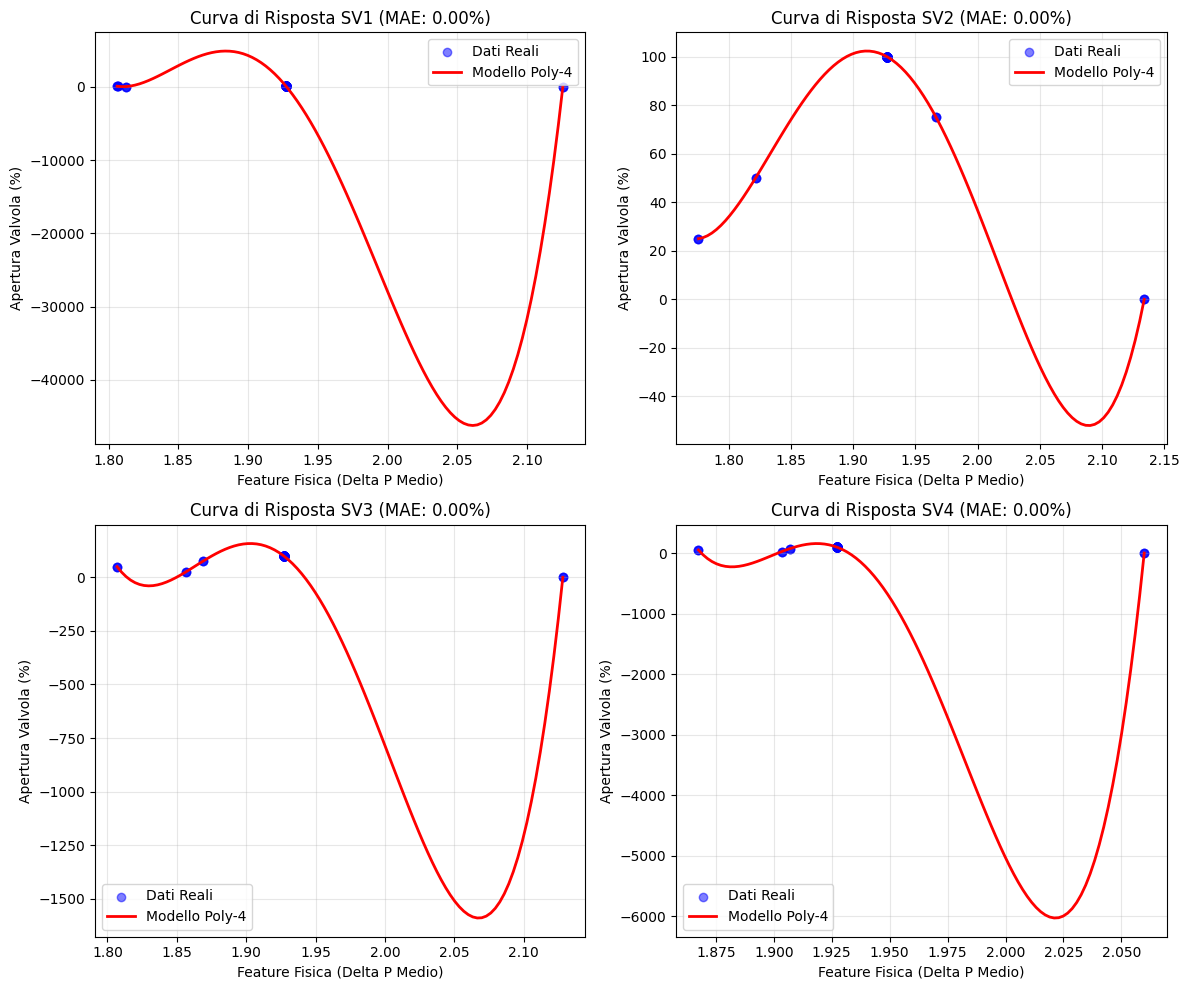

In [ ]:
# =============================================================================
# TASK 5: TRAINING & VALIDAZIONE (REGRESSIONE POLINOMIALE di 4° grado)
# 1. Feature Engineering: Calcolo Delta P (Max-Min) su P1, P2, P6.
# 2. Addestramento modelli distinti per SV1, SV2, SV3, SV4.
# 3. Validazione K-Fold per ogni valvola e visualizzazione curve.
# =============================================================================

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Funzione per estrarre la feature fisica (Delta P medio)
def extract_feature_deltap(df_rows):
    features = []
    for _, row in df_rows.iterrows():
        deltas = []
        # for s in ['P3', 'P4', 'P6', 'P7']:
        for s in ['P1', 'P2', 'P6']:
            sig = row[f'{s}_vec'] # Usiamo i vettori creati nel caricamento
            deltas.append(np.max(sig) - np.min(sig))
        features.append(np.mean(deltas))
    return np.array(features).reshape(-1, 1)

# Configurazioni
valves = [1, 2, 3, 4]
models_poly = {} # Dizionario per salvare i 4 modelli
poly = PolynomialFeatures(degree=4)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("--- ANALISI VALIDAZIONE TASK 5 (Polinomiale Deg=4) ---")

# Setup grafico per visualizzare le curve
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, v_id in enumerate(valves):
    # 1. Filtro Dati: Normali (100%) + Guasti specifici della valvola v_id
    mask = (df_train_lb['Target_Task1'] == 0) | (df_train_lb['Target_Task4'] == v_id)
    df_v = df_train_lb[mask].copy()

    # 2. Preparazione X (Delta P) e y (Opening Ratio)
    X_v = extract_feature_deltap(df_v)
    y_v = df_v['Target_Task5'].values

    # Trasformazione Polinomiale
    X_poly = poly.fit_transform(X_v)

    # 3. Cross-Validation
    model = LinearRegression()
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    scores = cross_val_score(model, X_poly, y_v, cv=cv, scoring=scorer)
    mae = -np.mean(scores)

    print(f"🔹 Valvola SV{v_id}: MAE Medio = {mae:.2f}% | Dati usati: {len(df_v)}")

    # 4. Addestramento Finale
    model.fit(X_poly, y_v)
    models_poly[v_id] = model

    # 5. Plot della Curva appresa
    ax = axes[i]
    # Punti reali
    ax.scatter(X_v, y_v, color='blue', alpha=0.5, label='Dati Reali')
    # Curva modello
    x_range = np.linspace(X_v.min(), X_v.max(), 100).reshape(-1, 1)
    y_range = model.predict(poly.transform(x_range))
    ax.plot(x_range, y_range, color='red', linewidth=2, label='Modello Poly-4')

    ax.set_title(f"Curva di Risposta SV{v_id} (MAE: {mae:.2f}%)")
    ax.set_xlabel("Feature Fisica (Delta P Medio)")
    ax.set_ylabel("Apertura Valvola (%)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# TASK 5: PREDIZIONE SUL TEST SET
# 1. Identifica i guasti valvola predetti nel Task 2 e 4.
# 2. Calcola Delta P e applica il modello specifico per la valvola.
# 3. Applica clipping (0-100%) per coerenza fisica.
# =============================================================================

# Inizializziamo a 100.0 (default)
df_test_lb['Task5_Pred'] = 100.0

# Maschera: Solo dove Task 2 dice "Valvola" (Classe 3)
mask_valves = df_test_lb['Task2_Pred'] == 3
indices_valves = df_test_lb[mask_valves].index

preds_values = []
preds_ids = []

if len(indices_valves) > 0:
    print(f"Stima apertura per {len(indices_valves)} valvole nel test set...")

    for idx in indices_valves:
        # Recuperiamo quale valvola è stata predetta nel Task 4
        v_id_pred = int(df_test_lb.loc[idx, 'Task4_Pred'])

        # Se il Task 4 ha fallito (0) o dato un valore strano, saltiamo o usiamo default
        if v_id_pred in models_poly:
            # Estrazione feature singola riga
            row_df = df_test_lb.loc[[idx]]
            X_feat = extract_feature_deltap(row_df)
            X_poly = poly.transform(X_feat)

            # Predizione
            pred_val = models_poly[v_id_pred].predict(X_poly)[0]

            # Clipping (Errore con aperture <0 o >100)
            pred_val = np.clip(pred_val, 0, 100)

            df_test_lb.at[idx, 'Task5_Pred'] = pred_val
            preds_values.append(pred_val)
            preds_ids.append(v_id_pred)
        else:
            # Fallback se la valvola non è identificata
            df_test_lb.at[idx, 'Task5_Pred'] = 50.0

    # --- ANALISI ANALITICA ---
    print(f"\n--- ANALISI ANALITICA TEST SET: TASK 5 (LB Poly) ---")

    # Statistiche generali
    stats_df = pd.DataFrame({'Valvola': preds_ids, 'Apertura': preds_values})
    print("\nStatistiche aperture per Valvola:")
    print(stats_df.groupby('Valvola')['Apertura'].agg(['mean', 'min', 'max', 'count']).round(2))

    # Confronto Spacecraft
    stats_df['Spacecraft'] = df_test_lb.loc[indices_valves, 'Spacecraft#'].values
    print("\nMedia Apertura per Spacecraft (Verifica Generalizzazione):")
    print(stats_df.groupby('Spacecraft')['Apertura'].mean().round(2))

else:
    print("Nessun guasto valvola da analizzare.")

Stima apertura per 10 valvole nel test set...

--- ANALISI ANALITICA TEST SET: TASK 5 (LB Poly) ---

Statistiche aperture per Valvola:
          mean  min    max  count
Valvola                          
3        60.79  0.0  100.0     10

Media Apertura per Spacecraft (Verifica Generalizzazione):
Spacecraft
1    56.59
4    65.00
Name: Apertura, dtype: float64


In [1]:
# =============================================================================
# GENERAZIONE FILE DI SUBMISSION FINALE (APPROCCIO 2 - LB)
# 1. Pulizia dati.
# 2. Formattazione descrittiva per la colonna "Test condition".
# 3. Salvataggio CSV finale.
# =============================================================================

# --- 1. PULIZIA DATI (Risolve l'errore NaN) ---
# Se una riga non è stata processata dai Task, deve avere un valore di default
for col in ['Task1_Pred', 'Task2_Pred', 'Task3_Pred', 'Task4_Pred']:
    if col in df_test_lb.columns:
        df_test_lb[col] = df_test_lb[col].fillna(0).astype(int)
    else:
        df_test_lb[col] = 0

# --- 2. FUNZIONE DI FORMATTAZIONE ---
def format_test_condition_lb(row):
    # Ora siamo sicuri che siano numeri validi
    t1 = int(row['Task1_Pred'])
    t2 = int(row['Task2_Pred'])
    t3 = int(row['Task3_Pred'])
    t4 = int(row['Task4_Pred'])
    t5 = row['Task5_Pred']

    if t1 == 0:
        return "Normal"
    elif t2 == 1:
        return "Unknown anomaly"
    elif t2 == 2:
        # Bolle: Task 3 (1-7 sono BP, 8 è BV1)
        pos_label = f"BP{t3}" if t3 <= 7 else "BV1"
        return f"Bubble anomaly ({pos_label})"
    elif t2 == 3:
        # Valvole: Task 4 indica quale SV (1-4)
        return f"Valve fault (SV{t4}, {round(t5, 1)}%)"
    return "N/A"

# Applichiamo la formattazione
df_test_lb['Test condition'] = df_test_lb.apply(format_test_condition_lb, axis=1)

# --- 3. CREAZIONE DATAFRAME FINALE ---
submission_finale_lb = pd.DataFrame({
    'Id': df_test_lb['Case#'].astype(int),
    'Task 1': df_test_lb['Task1_Pred'],
    'Task 2': df_test_lb['Task2_Pred'],
    'Task 3': df_test_lb['Task3_Pred'],
    'Task 4': df_test_lb['Task4_Pred'],
    'Task 5': df_test_lb['Task5_Pred'].round(2),
    'Test condition': df_test_lb['Test condition']
})

# Ordiniamo per Id
submission_finale_lb = submission_finale_lb.sort_values(by='Id')

# --- 4. SALVATAGGIO ---
OUTPUT_FILE_LB = "/content/drive/MyDrive/submission_Approccio2.csv"
submission_finale_lb.to_csv(OUTPUT_FILE_LB, index=False)

print(f"🚀 File di submission (APPROCCIO 2) generato con successo!")
print(f"Salvato in: {OUTPUT_FILE_LB}")

# Visualizzazione anteprima
display(submission_finale_lb.head(10))

# Analisi veloce
print("\n--- Riepilogo Finale Distribuzione ---")
print(submission_finale_lb['Test condition'].apply(lambda x: x.split('(')[0].strip()).value_counts())

NameError: name 'df_test_lb' is not defined